# ProbGust Vs Wind Gust Speed

Plot ProbGust Values against the Observed Wind Speed

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import scipy.stats       as stats
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()
start_direction = 0
end_direction = 360
sites = ['UMHM', '1KM']#['6S0']#['LVM', 'MTLWM', 'MTELV']#
site_observation_options = {
    "UMHM": {'wind_speed': None, 'correction': lambda a:a + pint.Quantity(9, units('mph')).to(units('m/s')).magnitude}
}

## Define utility functions

### load_forecast_grid:
Load time series from a gridded source converting units and filtering fields. Also creates the valid time field from reference time and time since reference. Can tranform column names if needed, ie for NBM 1 hour forecast.

In [3]:
def load_forecast_grid(filename, filter_fields=None, transform_columns=None):
    data = xr.open_dataset(filename).to_dataframe()
    if transform_columns is not None:
        data.columns = data.columns.to_series().apply(transform_columns)
    data['valid_time'] = data.reference_time + data.time_since_reference * hour
    data = data.set_index(['reference_time', 'valid_time']).sort_index()
    if filter_fields is None:
        filter_fields = data.columns
    return data[filter_fields]

### convert_units
Convert units of columns in a DataFrame

In [4]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### filter_missing_data
Filter rows that are filled with NaNs, ignoring time fields by default

In [5]:
def filter_missing_data(data):
    return data.dropna(how='all')

### load_observations
Load time series from observation source, converting units and filtering fields.

In [6]:
def load_observations(filename, filter_fields=None):
    data = xr.open_dataset(filename).to_dataframe().set_index('time').sort_index()
    if filter_fields is not None:
        data = data.loc[:, filter_fields]
    return data

### replace_missing_gust_with_wind
Since that gusts for AWOS/ASOS are not reported unless the gusts is sufficiently higher than sustained wind, replace missing gust values with the sustained to compare to RTMA / NBM that always has a gust value.

In [7]:
def replace_missing_gust_with_wind(data, wind_field, wind_gust_field):
    index = np.isnan(data[wind_gust_field])
    data.loc[index, wind_gust_field] = data[wind_field][index]

### get_period_maximum
Find the maximum values when rounding the time fields to nearest time period

In [8]:
def get_period_maximum(data, period='1H'):
    return data.groupby(data.index.round(period)).max()

### convert_units
Convert units of columns in a DataFrame

In [9]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### time_match_dataset
Time-match dataset while prefixing the columns of each dataset

In [10]:
def time_match_dataset(left, right, left_prefix='obs', right_prefix='grid', left_time='time', right_time='valid_time'):
    left_data = left.copy(deep=True)
    left_data.columns = ['{0:s}_{1:s}'.format(x, left_prefix) for x in left_data.columns]
    right_data = right.copy(deep=True)
    right_data.columns = ['{0:s}_{1:s}'.format(x, right_prefix) for x in right_data.columns]
    return pd.merge(left_data, right_data, how='inner', left_on='{0:s}_{1:s}'.format(left_time, left_prefix), right_on='{0:s}_{1:s}'.format(right_time, right_prefix)).reset_index()

### filter_three_hourly
Filter NBM data to 3 hourly forecast

In [11]:
def filter_three_hourly(data, time_field='valid_time'):
    return data[data.index.get_level_values(time_field).hour % 3 == 0]

### generate_probability
Calculate the Z-Score given the bias-corrected NBM mean wind gust and standard deviation

In [12]:
def generate_prob_gust(data, threshold, unit='mph', tollerance = 0.6, mean='10_meter_wind_speed_of_gust_mean', standard_deviation='10_meter_wind_speed_of_gust_standard_deviation'):
    threshold = pint.Quantity(threshold - tollerance, units(unit)).to(units('m s**-1')).magnitude
    z_score = pd.Series((threshold - data[mean]) / data[standard_deviation], index=data.index)
    return pd.Series(np.round((100 * normal_distribution.sf(z_score))), index=data.index)


### standard_error_of_estimate
calculate the standard error from a slope and intercept

In [13]:
def standard_error_of_estimate(x, y, slope, intercept):
    x = np.array(x)
    y = np.array(y)
    error = np.inf
    if len(x) > 2:
        error = np.sqrt(np.sum(((slope * x + intercept) - y)**2) / (len(x) - 2))
    return error

### expand_timelag
Duplicate a dataframe while adjusting a datetime field by an interval to create a time-lagged dataset

In [14]:
def expand_timelag(df, interval, field='reference_time'):
    df2 = df.copy(deep=True).reset_index()
    df2[field] += pd.to_timedelta(interval)
    return df2

### reliability_correction
apply a bias-correction to the ProbGust value to improve reliability

In [15]:
def reliability_correction(location, threshold, direction, prob_gust):
    slope = 1
    intercept = 0
    r = 1
    
    if location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 50 and 170 <= direction and direction <= 230:
        slope = 0.938000
        intercept = 18.523352
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 58 and 170 <= direction and direction <= 230:
        slope = 0.987953
        intercept = 18.602726
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 50 and 230 <= direction and direction <= 250:
        slope = 0.923174
        intercept = 5.761035
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 58 and 230 <= direction and direction <= 250:
        slope = 1.019796
        intercept = 4.567449
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 50 and 250 <= direction and direction <= 280:
        slope = 0.648766
        intercept = -4.546409
    elif location in ['MTLWM', 'MTELV', 'LVM'] and threshold == 58 and 250 <= direction and direction <= 280:
        slope = 0.910771
        intercept = -16.622423
    
    if intercept > 0:
        r = min(prob_gust / intercept, 1)
    
    if prob_gust > 1.01:
        prob_gust = max(min((1 - ((1 - slope) * r)) * prob_gust + (intercept * r), 100), 0)
    
    return prob_gust
        

### load_nbm_prob_gust
apply bias-correction and calculate ProbGust

In [16]:
def load_nbm_prob_gust(siteID, regression, thresholds, mean='10_meter_wind_speed_of_gust_mean', spread='10_meter_wind_speed_of_gust_standard_deviation', direction='10_meter_wind_from_direction_mean'):
    nbm_data = load_forecast_grid('../data/nbm_update/NBM_{0:s}.nc'.format(siteID), filter_fields=[mean, spread, direction])
    nbm_data = nbm_data[(nbm_data[direction] >= start_direction) & (nbm_data[direction] <= end_direction)][[mean, spread, direction]]
    nbm_data = filter_missing_data(nbm_data)
    nbm_data[mean] = regression.slope[siteID] * nbm_data[mean] + regression.intercept[siteID]
    for threshold in thresholds:
        nbm_data['ProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm_data, threshold)
        nbm_data['ProbGust_{0:d}'.format(threshold)] = nbm_data[['ProbGust_{0:d}'.format(threshold), direction]].apply(lambda a: reliability_correction(siteID, threshold, a[direction], a['ProbGust_{0:d}'.format(threshold)]), axis=1)
    return nbm_data[[col for col in nbm_data.columns if col.find('ProbGust') > -1]]

### load_wind_gust_observation
load the wind gust, optionally filling with wind speed if gust is missing and applying a correction

In [17]:
def load_wind_gust_observation(siteID, wind_speed='10_meter_wind_speed', wind_gust='10_meter_wind_speed_of_gust', correction=None):
    obs_data = load_observations('../data/observations/{0:s}.nc'.format(siteID), 
                                 filter_fields=[x for x in [wind_speed, wind_gust] if x is not None])
    if wind_speed is not None:
        replace_missing_gust_with_wind(obs_data, wind_speed, wind_gust)
    obs_data = obs_data[[wind_gust]].reset_index().set_index('time')
    if correction is not None:
        obs_data = correction(obs_data)
    obs_data['site_id'] = siteID
    return filter_missing_data(obs_data)

## Read Bias-Correction parameters

In [18]:
regression = pd.read_json('../data/derived/regressions.json', orient='table')
regression

,slope,intercept,rvalue,pvalue,stderr
MTELV,0.893859,6.923222,0.703279,1.471382e-186,0.025618
LVM,1.022861,4.676071,0.796859,0.000000e+00,0.018798
MTLWM,0.894840,7.826072,0.683627,2.977567e-138,0.030286
6S0,0.796994,8.129035,0.685876,3.758471e-201,0.022276
1KM,0.715568,8.136230,0.735165,1.881445e-130,0.023934
UMHM,0.695138,9.328585,0.715288,1.233256e-229,0.017768


## Load Observations

In [19]:
obs = pd.concat([ load_wind_gust_observation(x, **site_observation_options.get(x, {})) for x in sites]).reset_index()
obs.time = obs.time.dt.round('1H')
#.sort_values(['time'])
obs = obs.groupby(['time', 'site_id']).max().reset_index().set_index('time').sort_index()
convert_units(obs, {'10_meter_wind_speed_of_gust': ['m s**-1', 'mph']})
obs

,site_id,10_meter_wind_speed_of_gust
time,,
2020-05-18 01:00:00,1KM,0.000000
2020-05-18 02:00:00,1KM,9.206236
2020-05-18 03:00:00,1KM,5.753897
2020-05-18 04:00:00,1KM,5.753897
2020-05-18 05:00:00,1KM,5.753897
...,...,...
2022-01-08 08:00:00,UMHM,36.693271
2022-01-08 09:00:00,UMHM,41.189513
2022-01-08 10:00:00,UMHM,41.994810


## Load NBM Datasets
also create subsets for short and long term and filter data to 3 hourly for full NBM

In [20]:
nbm = pd.concat([load_nbm_prob_gust(x, regression, [50, 58, 75]).reset_index() for x in sites]).groupby(['reference_time', 'valid_time']).max()

nbm = nbm[(nbm.index.get_level_values(1) - nbm.index.get_level_values(0)).total_seconds()/3600 <= 36].copy(deep=True)
# nbm_short.columns = [x.replace('ProbGust', 'ShortProbGust') for x in nbm_short.columns]
# nbm_long = nbm[(nbm.index.get_level_values(1) - nbm.index.get_level_values(0)).total_seconds()/3600 >= 36].copy(deep=True)
# nbm_long.columns = [x.replace('ProbGust', 'LongProbGust') for x in nbm_long.columns]
# nbm = filter_three_hourly(nbm)

# for prob in [x for x in nbm.columns if x.find('ProbGust_') > -1]:
#     nbm[prob] = np.round(nbm[prob] / 10, 0) * 10
nbm = nbm.reset_index().set_index('valid_time')
nbm = nbm.melt(value_vars=[x for x in nbm.columns if x.find('ProbGust_') > -1], var_name='Threshold', value_name='Probability', ignore_index=False).sort_index()
nbm.Probability = np.round(nbm.Probability / 10, 0) * 10
nbm

,Threshold,Probability
valid_time,,
2020-10-01 10:00:00,ProbGust_50,0.0
2020-10-01 10:00:00,ProbGust_75,0.0
2020-10-01 10:00:00,ProbGust_58,0.0
2020-10-01 11:00:00,ProbGust_50,0.0
2020-10-01 11:00:00,ProbGust_75,0.0
...,...,...
2021-11-06 10:00:00,ProbGust_58,0.0
2021-11-06 10:00:00,ProbGust_50,0.0
2021-11-06 11:00:00,ProbGust_58,0.0


In [21]:
prob_v_obs = pd.merge(left=nbm, right=obs, left_index=True, right_index=True).reset_index()

if len(sites) > 1:
    prob_v_obs_all = prob_v_obs.copy(deep=True)
    prob_v_obs_all.site_id = 'ALL'
    prob_v_obs = pd.concat([prob_v_obs, prob_v_obs_all])
prob_v_obs = prob_v_obs.reset_index(drop=True).sort_values(['index', 'Threshold', 'Probability', 'site_id'])
prob_v_obs

,index,Threshold,Probability,site_id,10_meter_wind_speed_of_gust
0,2020-10-01 10:00:00,ProbGust_50,0.0,1KM,8.055456
61548,2020-10-01 10:00:00,ProbGust_50,0.0,ALL,8.055456
61549,2020-10-01 10:00:00,ProbGust_50,0.0,ALL,13.608089
1,2020-10-01 10:00:00,ProbGust_50,0.0,UMHM,13.608089
4,2020-10-01 10:00:00,ProbGust_58,0.0,1KM,8.055456
...,...,...,...,...,...
61543,2021-11-06 11:00:00,ProbGust_58,0.0,UMHM,17.500358
61546,2021-11-06 11:00:00,ProbGust_75,0.0,1KM,9.206236
123094,2021-11-06 11:00:00,ProbGust_75,0.0,ALL,9.206236
123095,2021-11-06 11:00:00,ProbGust_75,0.0,ALL,17.500358


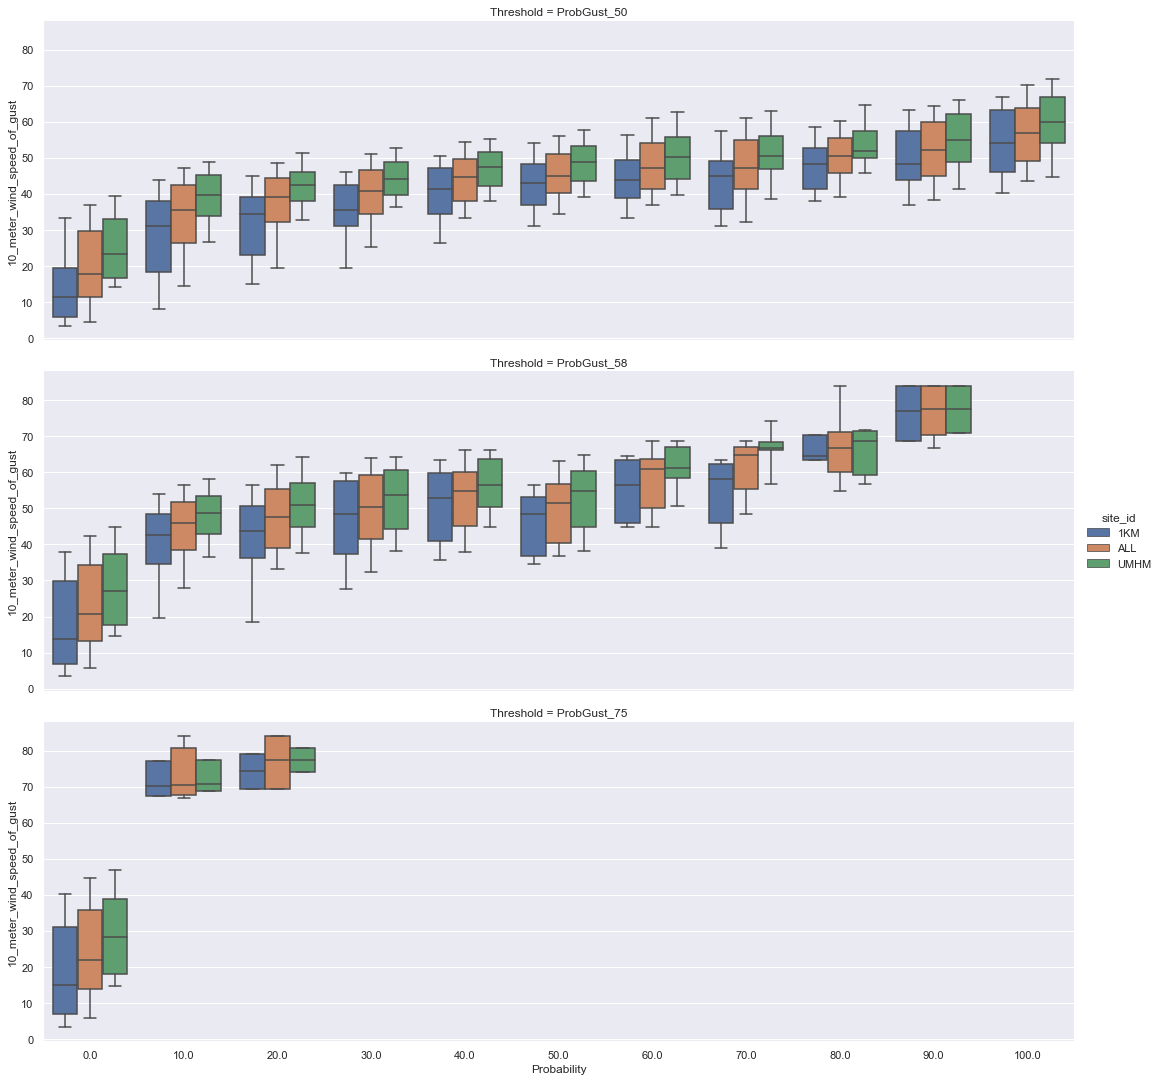

In [22]:
g = sns.catplot(x="Probability", y="10_meter_wind_speed_of_gust",
                row="Threshold", hue='site_id', data=prob_v_obs, kind='box', aspect=3, whis=[10,90], showfliers=False)
g.set(yticks=range(0,90,10))
g.savefig('output/' + sites[0] + '_prob_vs_gust.png' )